### OC spatial structure

- 2D, 3D structure
- Model fitting
- tidal, core radii


In [14]:
using PyCall
using Distributions, Statistics, Distances
using DataFrames
using  LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc"

cd(wdir)

In [15]:
## radial functions
##

function volumeSphere(r)
    return(4 / 3 * π * r^3)
end

function areaDisk(r)
    return(4 * π * r^2)
end

function _density2D(x , y , nbin=10)
    center= [mean(x) ; mean(y)]
    
    nxy= length(x)
    A= Array{Float64}(undef,2,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err= []
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(areaDisk(r1)-areaDisk(r0))
        errDensity= dens / sqrt(nstar)
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

function _density3D(x , y , z, nbin=10)
    center= [mean(x) ; mean(y) ; mean(z)]
    println(center)
    println(nbin)
    
    nxy= length(x)
    A= Array{Float64}(undef,3,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
        A[3,i]= z[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err=[]
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(volumeSphere(r1)-volumeSphere(r0))
        errDensity= dens / sqrt(nstar)
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

_density3D (generic function with 2 methods)

In [16]:
## Estimation of the local density around each point
## nei: number of neighbor to estimate the density
##

function _locdens2d(x , y , nei=2)
    nxy= length(x)
    println(nxy)
    A= Array{Float64}(undef,2,nxy)
    center= [mean(x) ; mean(y)]
    
    for i in 1:nxy
        A[:,i]= [x[i] y[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    r= Distances.colwise(d, A, center)
    locdensrad= []
    
    for i in 1:nxy
        rsort= sort(p[i,:])
        rmax= rsort[nei+1]
        locdens= (nei+1)/areaDisk(rmax)
        push!(locdensrad, locdens)
    end
    
    return(r,locdensrad)
end

_locdens2d (generic function with 2 methods)

In [17]:
#oc= CSV.read("$ocdir/NGC 6124-2.3deg-oc.csv" , delim= ";")
# oc= CSV.read("$ocdir/NGC 7086-1.0deg-oc.csv", delim= ";")
# oc= CSV.read("$ocdir/NGC 2516-3.5deg-oc.csv", delim= ";")
oc= CSV.read("test.csv", delim= ";")

r2d,ρ2d,err2d= _density2D(oc[:Y], oc[:Z],20)
r3d,ρ3d,err3d= _density3D(oc[:X], oc[:Y], oc[:Z],20)
rad2d, locdens2d= _locdens2d(oc[:Y], oc[:Z], 20)

println(r3d)
println(ρ3d)

[264.085, 3.62119, 2.16915]
20
559
Any[1.28813, 3.86438, 6.44064, 9.01689, 11.5931, 14.1694, 16.7457, 19.3219, 21.8982, 24.4744, 27.0507, 29.6269, 32.2032, 34.7794, 37.3557, 39.9319, 42.5082, 45.0844, 47.6607, 50.237]
Any[0.0139619, 0.0578423, 0.027189, 0.0139619, 0.0105287, 0.00690425, 0.00384778, 0.00247845, 0.00231626, 0.00149408, 0.00130761, 0.00098472, 0.00110147, 0.000663638, 0.00059742, 0.000639034, 0.000427232, 0.000167118, 0.000149544, 6.11829e-5]


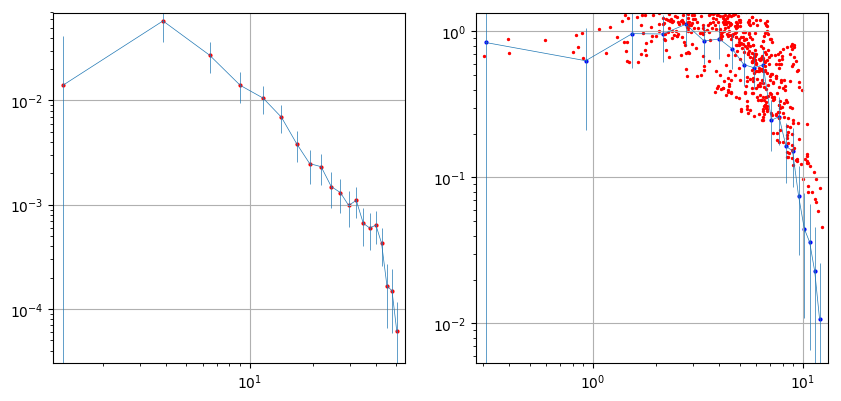

In [18]:
fig= PyPlot.figure(figsize=(10,10))
ax= PyPlot.subplot(221)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r3d[1]*0.9, r3d[end]*1.1)
ax.set_ylim(minimum(ρ3d[ρ3d .> 0])*0.5,maximum(ρ3d)*1.2)
PyPlot.grid("on")
PyPlot.scatter(r3d, ρ3d , s=4, facecolor="red" )
PyPlot.errorbar(r3d, ρ3d, yerr=2 .* err3d, linewidth=0.5)

ax= PyPlot.subplot(222)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.5,maximum(ρ2d)*1.2)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
PyPlot.scatter(rad2d, locdens2d , s=2, facecolor="red" )

PyPlot.show()

We try to fit the radial density (using MCMC?). It will be used later for the fractal dimension (including the radial density inside).

## Fitting the radial profile


In [19]:
## position from the gravity centered
struct _sc2d
    nxy::Int
    xx::Array{Float64}
    yy::Array{Float64}
    radius::Array{Float64}
    dens::Array{Float64}
end

## prior model / mcmc
mutable struct _mcmc2d
    Cmean::Float64
    Cdisp::Float64
    smean::Float64
    sdisp::Float64
    mmean::Float64
    mdisp::Float64
    nburnin::Int
    niter::Int
end

mutable struct _mc2d
    C::Array{Float64}
    s::Array{Float64}
    m::Array{Float64}
end

In [20]:
function _fdens1(r, θ::_mc2d)
    r2= r*r
    s2= θ.s*θ.s
    val = θ.C / (1+r2/s2)^θ.m
    return(val)
end

## 
function _likelihood2d(θ::_mc2d, oc::_sc2d)
    χ2= 0
    for i in 1:length(oc.radius)
        desti= _fdens1(oc.radius[i], θ)
        χ2+= (desti-oc.dens[i])^2     ## σ=1
    end
    return(χ2)
end

_likelihood2d (generic function with 2 methods)

# Metropolis-Hasting

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

proposal = norm(mu_current, proposal_width).rvs()

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

likelihood_current = norm(mu_current, 1).pdf(data).prod() <br>
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() <br>

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) <br>
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) <br>

# Nominator of Bayes formula
p_current = likelihood_current * prior_current <br>
p_proposal = likelihood_proposal * prior_proposal <br>

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the mu_proposal has higher likelihood than mu_current. Eventually we'll get to mu = 0 (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

p_accept = p_proposal / p_current <br> 

we get an acceptance probability. You can already see that if p_proposal is larger, that probability will be > 1 and we'll definitely accept. However, if p_current is larger, say twice as large, there'll be a 50% chance of moving there:

accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

In [22]:
function _theta2d(oc::_sc2d)
    
end

## next iteration
function _theta2diter(θi::_model)
    
end

_theta2diter (generic function with 1 method)

In [ ]:
function main_mcmc(oc, mcmc::_mcmc2d)
    let
        rad2d, locdens2d= _locdens2d(oc[:Y], oc[:Z], 3)
        mci = _mc2d(zeros(Float64,0),zeros(Float64,0),zeros(Float64,0))
        
        mi, probi = _theta2d(params)
        println("## Init 2D done...")
    
        nchain = 1
        loopAgain = true
        burndone = false
                    
        while loopAgain
            micurrent, probcurrent = thetaiter(mi , params)
   
        ### Metropolis-Hasting
            α = probcurrent / probi
            if α > rand() 
                mi = micurrent
                probi = probcurrent
                nchain += 1
                if (nchain%500 == 0) println("### chain:",nchain) end
                if nchain > nburn && !burndone println("### burnout done...") ; nchain = 0 ; burndone = true end
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end
            else
                nchain += 1
                if (nchain%500 == 0) println("### chain:",nchain) end
                if nchain > nburn && !burndone println("### burnout done...") ; nchain = 0 ; burndone = true end
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end                    
            end
        end
        println("## MCMC 2D fitting done.") 
        
        return(mci)
end